In [1]:
%matplotlib inline

import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import copy
import pandas as pd
from sklearn.utils import shuffle
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from math import floor
import random

import sys
sys.path.append('/home/r120084/pytorch_lib/pytorch/')
import lib.pytorch_trainer as ptt


use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


In [2]:
path2data = '/home/r120084/data/'

In [3]:
path2trainData = path2data + 'train/training.csv'
path2testData = path2data + 'test/test.csv'

In [42]:
class FaceKeyPointsDataset(Dataset):

    def __init__(self, path2data, val_size = 0.1, dropnan = True, transforms=None,
                 is_valid=False, is_test=False, is_train = False):
        
        
        self.transform = transforms    
        self.df = pd.read_csv(path2data)
        if dropnan:
            self.df = self.df.dropna()

        self.df['Image'] = self.df['Image'].apply(lambda im: self.get_image(im))
        self.get_X()
        
        if ( (is_train) or (is_valid)):
            self.get_train_target() 
            if is_valid:
                self.split_data(val_size)
            self.normalize_target()
            
        if is_test:
            self.get_test_target()
                 
    def normalize_target(self):
        #self.y = (self.y- self.y.max()) /self.y.max()
        self.y = (self.y - 48) / 48 
        self.y = self.y.astype(np.float32)

 
    def _show_keys(self):
         print(self.df.dtypes)

    def get_image(self, x):
        x = np.fromstring(x, sep = ' ')
        return x

    def get_X(self):

        self.X = np.vstack(self.df['Image'].values) / 255.  # scale pixel values to [0, 1]
        self.X = self.X.astype(np.float32)
        self.X = self.X.reshape(-1, 1, 96, 96) # return each images as 1 x 96 x 96

    def get_train_target(self):

        self.y = self.df[self.df.columns[:-1]].values

    def get_test_target(self):
        self.y = np.zeros(len(self.X))

    def split_data(self, val_size = 0.1):

        np.random.seed(4572)
        indices = range(len(self.X))

        ind = np.random.permutation(indices)
        split = np.round(val_size * len(self.X))
        index= np.array(ind[:split])
        
        self.X = self.X.take(index,axis=0)
        self.y = self.y.take(index,axis=0)
    
    def __getitem__(self, index):
        image = self.X[index]
        
        label = self.y[index]
        #documentar 96x1x96
        #if self.transform is not None:
        #    image = self.transform(image)
        return image, label

         
    # documentar no pytorch
    def __len__(self):
        return len(self.X)

In [43]:
batch_size = 32

In [44]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor()

    ]),
    'valid': transforms.Compose([
        transforms.ToTensor()
    ]),
}

In [45]:
dsets = {
    'train': FaceKeyPointsDataset(path2trainData, transforms=data_transforms['train'], is_train = True),
    'valid': FaceKeyPointsDataset(path2trainData, transforms=data_transforms['valid'], is_valid=True),
    'test':  FaceKeyPointsDataset(path2testData, transforms=data_transforms['valid'], is_test=True),
}

/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [46]:
if use_gpu:
    
    dset_loaders = {
        'train': DataLoader(dsets['train'], batch_size=batch_size, shuffle=True,  pin_memory=True),
        'valid': DataLoader(dsets['valid'], batch_size=batch_size, shuffle=False,  pin_memory=True),
        'test':  DataLoader(dsets['test'],  batch_size=batch_size, shuffle=False,  pin_memory=True),
    }
else:
    
    dset_loaders = {
        'train': DataLoader(dsets['train'], batch_size=batch_size, shuffle=True),
        'valid': DataLoader(dsets['valid'], batch_size=batch_size, shuffle=False),
        'test':  DataLoader(dsets['test'],  batch_size=batch_size, shuffle=False),
    }

In [47]:
dsets['train']._show_keys()

left_eye_center_x            float64
left_eye_center_y            float64
right_eye_center_x           float64
right_eye_center_y           float64
left_eye_inner_corner_x      float64
left_eye_inner_corner_y      float64
left_eye_outer_corner_x      float64
left_eye_outer_corner_y      float64
right_eye_inner_corner_x     float64
right_eye_inner_corner_y     float64
right_eye_outer_corner_x     float64
right_eye_outer_corner_y     float64
left_eyebrow_inner_end_x     float64
left_eyebrow_inner_end_y     float64
left_eyebrow_outer_end_x     float64
left_eyebrow_outer_end_y     float64
right_eyebrow_inner_end_x    float64
right_eyebrow_inner_end_y    float64
right_eyebrow_outer_end_x    float64
right_eyebrow_outer_end_y    float64
nose_tip_x                   float64
nose_tip_y                   float64
mouth_left_corner_x          float64
mouth_left_corner_y          float64
mouth_right_corner_x         float64
mouth_right_corner_y         float64
mouth_center_top_lip_x       float64
m

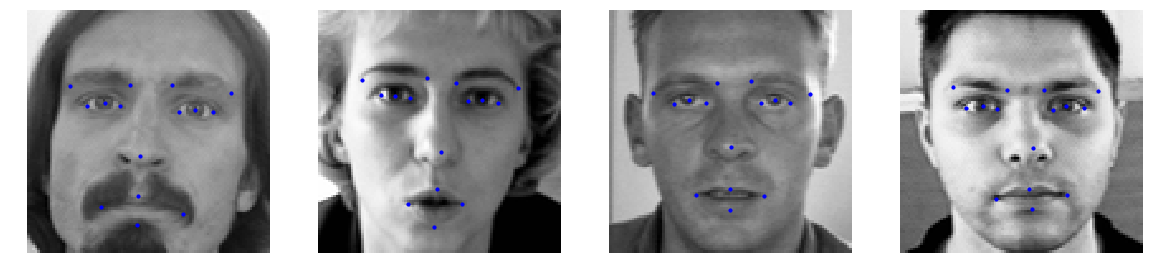

In [48]:
plt.figure(figsize=(20,5))
for i in range(0, 4):
    plt.subplot(1,4,i+1)
    try:
        X = dsets['train'][i][0].numpy()
        print(X.shape)
        img = X.transpose((1, 2, 0))
    except:
        img = dsets['train'][i][0]
    img = np.squeeze(img)
    y =  dsets['train'][i][1]
    cordinates = y* 48 + 48
    plt.imshow(img, cmap = 'gray')
    plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
    plt.axis('off')

In [49]:
nb_out = 30

In [73]:
class myconvNet(nn.Module):

    def __init__(self, image_size=(1,96,96)):
        super(myconvNet, self).__init__()  
        
        self.conv1 = nn.Conv2d(image_size[0], 24, kernel_size=5)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5)
        self.pool2 = torch.nn.MaxPool2d(2, 2)


        self.conv3 = nn.Conv2d(36, 48, kernel_size=5)
        self.pool3 = torch.nn.MaxPool2d(2, 2)


        self.conv4 = nn.Conv2d(48, 64, kernel_size=5)
        self.pool4 = torch.nn.AvgPool2d(2, 2)
        
        feature_size = self._get_conv_output(image_size)
        
        self.fc1 = nn.Linear(feature_size, 128)    
        self.drop_dense1 = torch.nn.Dropout(0.25)

        self.fc2 = nn.Linear(128, 64)
        self.drop_dense2 = torch.nn.Dropout(0.5)

        self.fc3 = nn.Linear(64, nb_out)

        
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop_dense1(x)
        x = F.relu(self.fc2(x))
        x = self.drop_dense2(x)
        x = self.fc3(x)
        return x
    
    
    def _forward_features(self, x): 
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)     
        return x
    
    
    def _get_conv_output(self, shape):
        bs = 1
        input = Variable(torch.rand(bs, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size
    

In [74]:
myconvNet = myconvNet()
if use_gpu:
    myconvNet = myconvNet.cuda()

In [75]:
print(myconvNet)

myconvNet (
  (conv1): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv4): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool4): AvgPool2d (size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
  (fc1): Linear (256 -> 128)
  (drop_dense1): Dropout (p = 0.25)
  (fc2): Linear (128 -> 64)
  (drop_dense2): Dropout (p = 0.5)
  (fc3): Linear (64 -> 30)
)


In [76]:
def prediction(loader, model, loss_fn):
    for i, data in enumerate(loader):     
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels) 
        # forward pass
        outputs = model(inputs)
        # loss
        loss = loss_fn(outputs, labels)
    return (loss.data[0])

In [77]:
def train(model, train_loader, test_loader ,num_epochs, loss_fn, optimizer, patience  ):
    
    history_loss = []
    loss_train = []
    loss_test = []
    best_test_acc =  np.inf
    patience_count= 0
    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            predict = model(inputs)
            loss = loss_fn(predict, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

        loss_train.append(prediction(train_loader, model,loss_fn) )
        loss_test.append( prediction(test_loader, model,loss_fn) )
        history_loss.append(loss.data[0])
        
        print('Epoch:', epoch, ' Loss Train: ', loss_train[-1],  ' Lost Test: ', loss_test[-1])

        #Early stopping
        if(best_test_acc < loss_test[-1]):
            patience_count = 0
            best_test_acc = loss_test[-1]
            best_model = copy.deepcopy(model)

        if(patience_count > patience):
            break;

        patience_count += 1
        
        
    print('Done!')
    return history_loss, loss_train, loss_train, model 

In [78]:
loss_fn = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(myconvNet.parameters()) 
optimizer =  optim.RMSprop(myconvNet.parameters(), lr=1e-3)
#lr = 0.1
#optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
num_epochs = 5
patience = 2

In [79]:
params = {'model' : myconvNet, 
        'train_loader':dset_loaders['train'],
         'test_loader':dset_loaders['valid'],
         'num_epochs': num_epochs,
         'loss_fn': loss_fn,
        'optimizer': optimizer, 
         'patience': patience 
         }

In [80]:
history_loss, loss_train, loss_train, model   = train(**params)

Epoch: 0  Loss Train:  0.021347615867853165  Lost Test:  0.02212134376168251
Epoch: 1  Loss Train:  0.05835958942770958  Lost Test:  0.054011519998311996
Epoch: 2  Loss Train:  0.01464582048356533  Lost Test:  0.011015416122972965
Epoch: 3  Loss Train:  0.01217322051525116  Lost Test:  0.013750831596553326
Done!


In [81]:
def predict(model, dset_loaders, use_gpu = False):

    predictions = []
    if use_gpu:
        use_gpu = torch.cuda.is_available()

    model.train(False)  # Set model to evaluate mode
    ii_n = len(dset_loaders)
    for ii, (image, labels) in enumerate(dset_loaders):
        if use_gpu:
            image = Variable(image.cuda())
        else:
            image = Variable(image)
        outputs = model.forward(image)
        predictions.append(outputs.data.cpu())
        print('\rpredict: {}/{}'.format(ii, ii_n - 1), end='')
    print(' ok')
    if len(predictions) > 0:
        return torch.cat(predictions, 0)

In [82]:
preds_test = predict(myconvNet, dset_loaders['test'])
preds_train = predict(myconvNet, dset_loaders['train'])

predict: 55/55 ok
predict: 66/66 ok


In [83]:
(preds_test.shape, preds_train.shape)

(torch.Size([1783, 30]), torch.Size([2140, 30]))

(2140, 30)
(2140, 30)
(2140, 30)
(2140, 30)


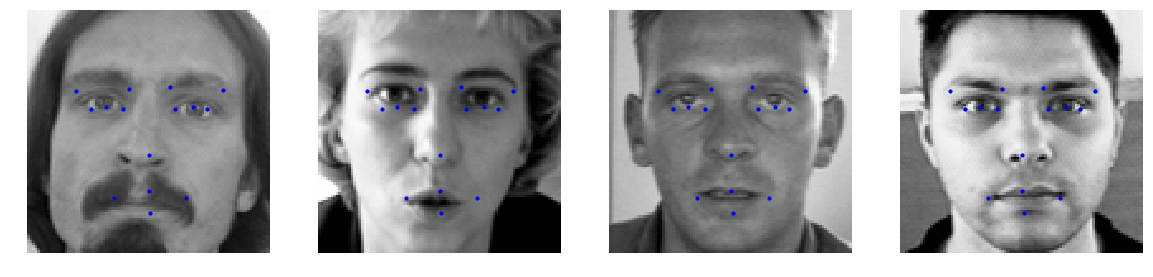

In [84]:
plt.figure(figsize=(20,5))
for i in range(0, 4):
    plt.subplot(1,4,i+1)
    try:
        X = dsets['train'][i][0].numpy()
        img = X.transpose((1, 2, 0))
    except:
        img = dsets['train'][i][0]
    img = np.squeeze(img)
    y = preds_train.numpy()
    cordinates = y[i]*48 + 48
    plt.imshow(img, cmap = 'gray')
    plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
    plt.axis('off')

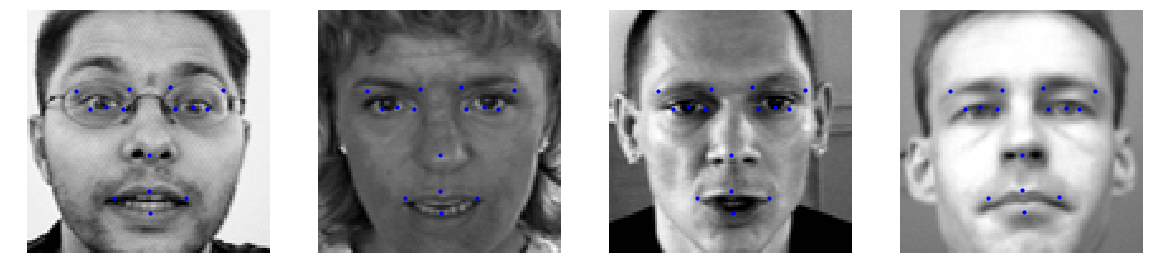

In [85]:
plt.figure(figsize=(20,5))
for i in range(0, 4):
    plt.subplot(1,4,i+1)
    try:
        X = dsets['test'][i][0].numpy()
        print(X.shape)
        img = X.transpose((1, 2, 0))
    except:
        img = dsets['test'][i][0]
    img = np.squeeze(img)
    y = preds_test.numpy()
    cordinates = y[i]* 48 + 48
    plt.imshow(img, cmap = 'gray')
    plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
    plt.axis('off')

In [86]:
id_lookup_frame = pd.read_csv(path2data + "IdLookupTable.csv")
val_reqrd = id_lookup_frame[["ImageId", "FeatureName"]]
val_reqrd.head()

,ImageId,FeatureName
0,1,left_eye_center_x
1,1,left_eye_center_y
2,1,right_eye_center_x
3,1,right_eye_center_y
4,1,left_eye_inner_corner_x


In [87]:
y_test= preds.numpy() * 48  + 48
columns = dsets['train'].df.columns[:-1]

In [88]:
def generate_output_submission(y_test, columns, filename = "result.csv"):
    y_res = []
    j = 0
    k = 0
    m = 0
    for i in range(1, len(y_test)+1):
        img = np.array(val_reqrd[val_reqrd["ImageId"]==i])
        if img.shape[0] == 30:
            y_res += list(y_test[i-1,:])
            j += 30
        else:
            slice_img = y_test[i-1, :]
            y_res += [slice_img[j] for j in range(30) if columns[j] in img[:, 1]]
            k += len([slice_img[j] for j in range(30) if columns[j] in img[:, 1]])
    y_res = np.array(y_res)

    
    result_dict = {
    "RowId": range(1,y_res.shape[0]+1),
    "Location": y_res%96
    }
    result_df = pd.DataFrame(result_dict, )
    result_df.to_csv(filename, index=False, columns=["RowId", "Location"])
    print('Done!')

In [89]:
generate_output_submission(y_test, columns)

Done!
